# Within-SH segment class analysis
UMAP on SH segments to determine whether there is any within-class variation that can be described by the labelled predictors. 
Here, we run the UMAP and evaluation of the projection will take place in a separate notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [5]:
from scipy.stats import kruskal

In [6]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [7]:
DATASET_ID = "git_repos"

In [8]:
DT_ID = '2022-03-04_18-41-29'

In [10]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_umap_combinedtidied.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]",DS,DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]",SH,DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]",DS,DS-SH-DS,DS-SH-DS SH-LH


In [11]:
seg_df = seg_df.loc[(seg_df["comb_labels"]=="SH")]
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]",SH,DS-SH-DS,DS-SH-DS SH-LH
3,0.932017,0.942875,SH,3,0.932017,0.942875,SHSHLH,0.932017,0,1,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[6.1701107, 8.522725]",SH,SH-LH,DS-SH-DS SH-LH
4,0.951561,0.980101,SH,4,0.951561,0.980101,SHSHLH,0.932017,1,1,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.8798895, 8.7029915]",SH,SH-LH,DS-SH-DS SH-LH


In [13]:
seg_df.sort_values(by=['ID'], inplace=True)

In [14]:
#How many segments does each individual have?
label_dfs = []
for indv in np.sort(seg_df.indv.unique()):
    label_df = pd.DataFrame({len(seg_df[seg_df.indv == indv].ID.unique())})
    label_df.insert(0, 'indv', indv)
    label_dfs.append(label_df)
l_df = pd.concat(label_dfs)
l_df.sort_values(by=['indv'])
l_df[:]

,indv,0
0,BMYO,18
0,GBYM,30
0,GON XF 19-21,19
0,GON XM 20-21,1
0,MGGY,30
0,MOGO,41
0,MOOO,9
0,MRGO,62
0,MXWW,8
0,MXXGRY,37


### Reduce Numbers for MRGO & OMGO

In [15]:
OMGO_df = seg_df.loc[(seg_df["indv"]=="OMGO")]
OMGO_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
2,12.607988,12.631858,SH,726,12.607988,12.631858,SHSHNLDS,12.607988,0,301,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MBG OMGO Alert and Combo Series 1 200220 AM b,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.324805, 4.8671527]",SH,SH-NL-DS,NL-DS SH-NL-DS DS-SH-DS SH-LH
3,12.636243,12.656856,SH,727,12.636243,12.656856,SHSHNLDS,12.607988,1,301,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MBG OMGO Alert and Combo Series 1 200220 AM b,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.3087063, 4.840088]",SH,SH-NL-DS,NL-DS SH-NL-DS DS-SH-DS SH-LH
7,13.095293,13.126673,SH,731,13.095293,13.126673,DSSHDS,13.065043,1,302,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MBG OMGO Alert and Combo Series 1 200220 AM b,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.0991993, 6.5987654]",SH,DS-SH-DS,NL-DS SH-NL-DS DS-SH-DS SH-LH


In [16]:
segs = [i for i in OMGO_df.ID.unique()]
df = pd.DataFrame(segs)
df = df.astype(int)
samps = df.sample(frac = 0.5) 
ds = list(samps[0])
len(ds)

44

In [17]:
OMGO_df2 = OMGO_df.loc[OMGO_df.ID.isin(ds)]  ##subset dataframe of sequences if their number is in random sample
len(OMGO_df2)

44

In [18]:
MRGO_df = seg_df.loc[(seg_df["indv"]=="MRGO")]
MRGO_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
2,1.007966,1.068826,SH,81,1.007966,1.068826,SHDS,1.007966,0,33,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWYb BMYB Discrete Series 1 OVMO Discrete Seri...,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.8355846, 9.987975]",SH,SH-DS,NL-DS SH-DS
1,0.158949,0.203640,SH,84,0.158949,0.203640,DSSHDS,0.089255,1,34,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWYb MRGO Call Combo 1 170221 AM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.970713, 10.174946]",SH,DS-SH-DS,DS-SH-DS NL-SH-DS SH-DS SH-LH
4,0.536026,0.552388,SH,87,0.536026,0.552388,NLSHDS,0.460304,1,35,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWYb MRGO Call Combo 1 170221 AM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.4459586, 7.096097]",SH,NL-SH-DS,DS-SH-DS NL-SH-DS SH-DS SH-LH


In [19]:
segs = [i for i in MRGO_df.ID.unique()]
df = pd.DataFrame(segs)
df = df.astype(int)
samps = df.sample(frac = 0.7) 
ds = list(samps[0])
len(ds)

43

In [20]:
MRGO_df2 = MRGO_df.loc[MRGO_df.ID.isin(ds)]  ##subset dataframe of sequences if their number is in random sample
len(MRGO_df2)

43

In [21]:
##Attach to others
other_df = seg_df[seg_df["indv"].isin(["OMGO", "MRGO"])==False] #without VVVM or OMGO
other_df.indv.unique()

array(['MGGY', 'VVOM', 'BMYO', 'GON XF 19-21', 'GON XM 20-21', 'GBYM',
       'MOGO', 'MOOO', 'PMXRMX', 'XF 20-21', 'RMYG', 'RMXGMX', 'VVVM',
       'MXWW', 'SCL XF 20-21', 'SCL XM 20-21', 'MXXGRY'], dtype=object)

In [22]:
frames = [other_df, OMGO_df2, MRGO_df2]
seg_df2 = pd.concat(frames)

In [23]:
len(seg_df2)

427

BMYO 18


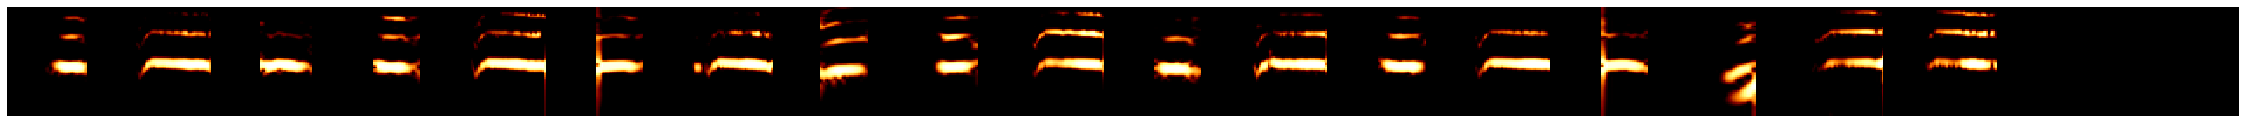

GBYM 30


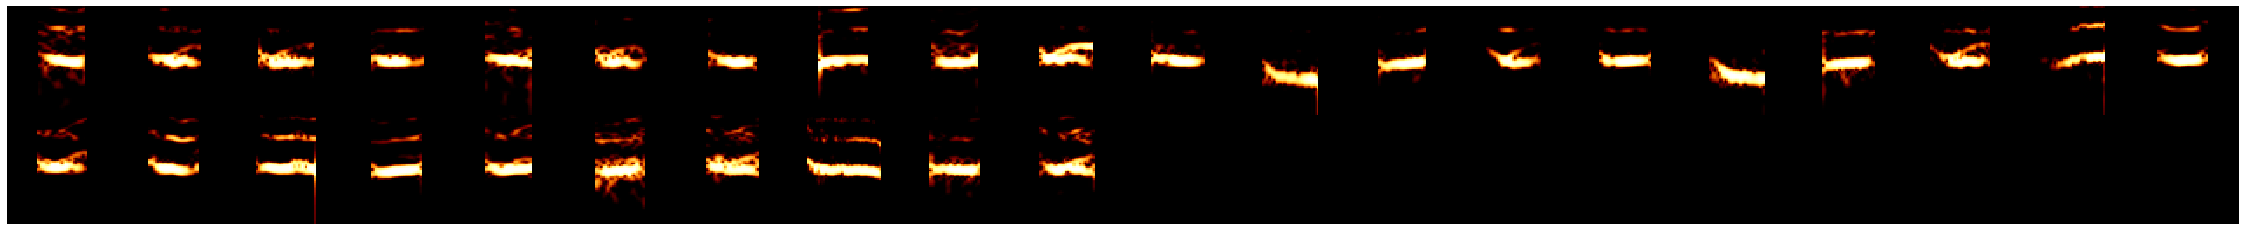

GON XF 19-21 19


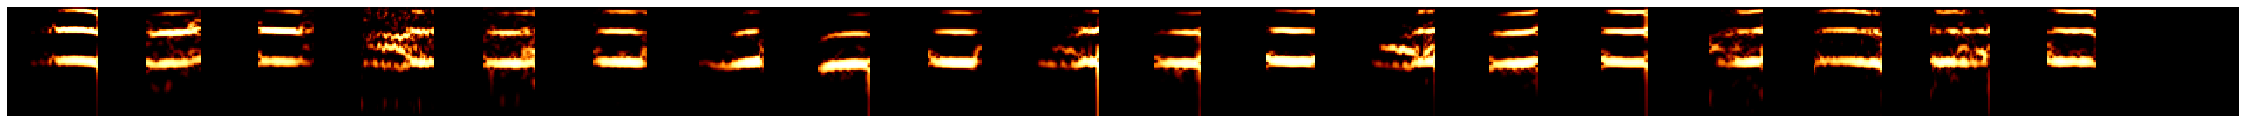

GON XM 20-21 1


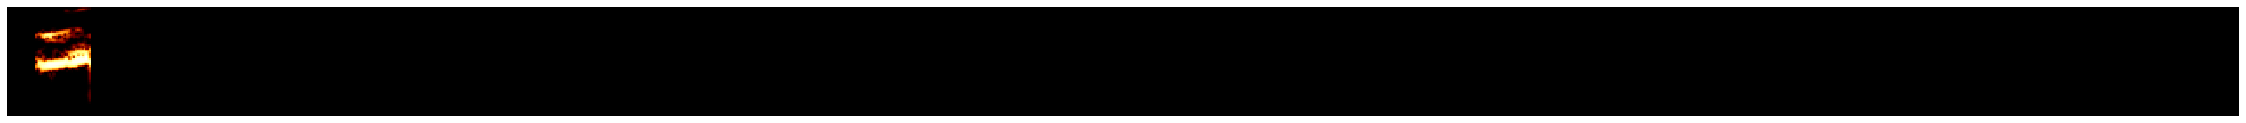

MGGY 31


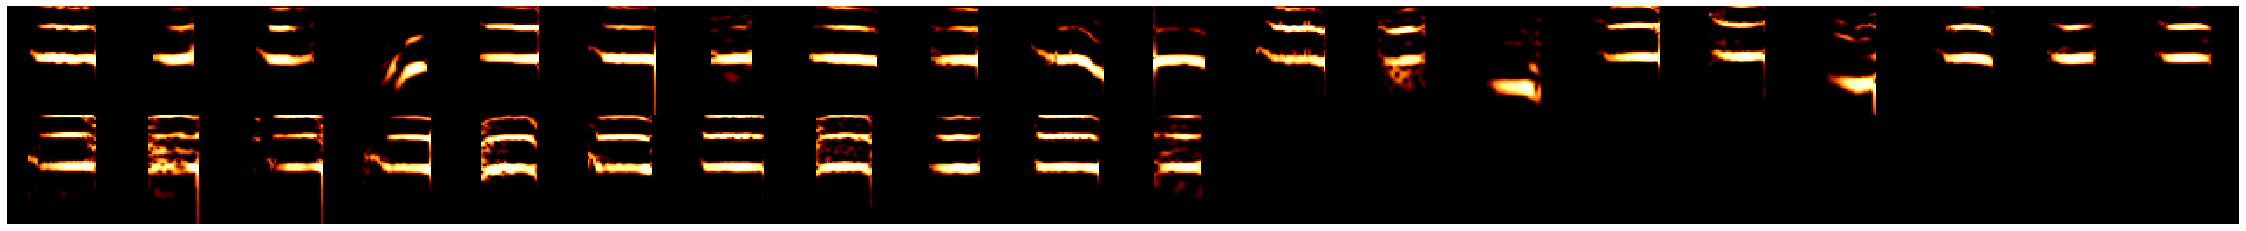

MOGO 41


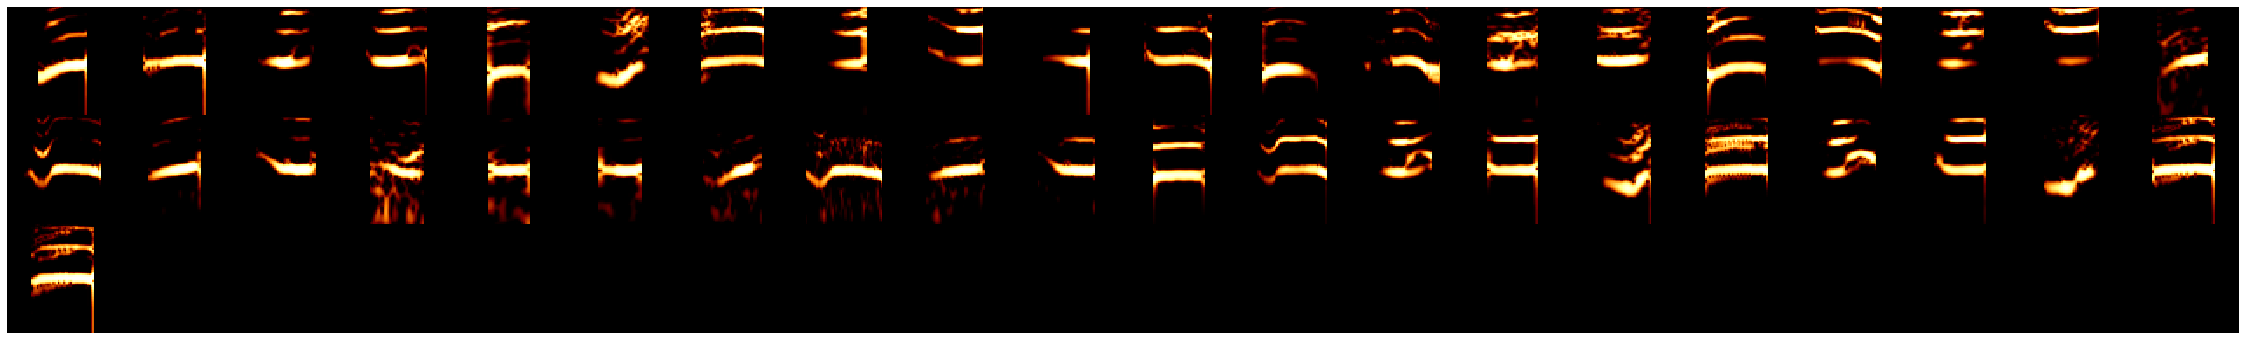

MOOO 9


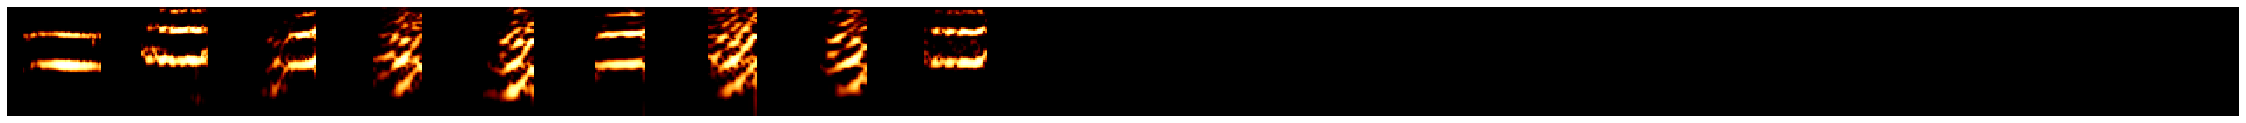

MRGO 43


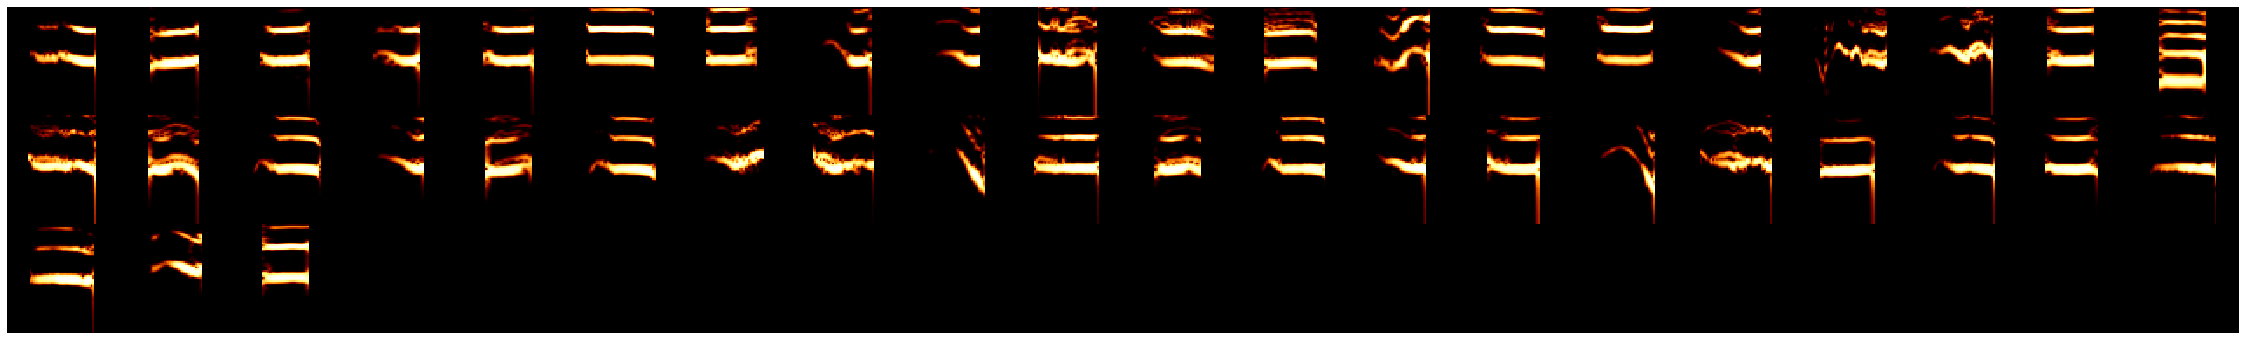

MXWW 8


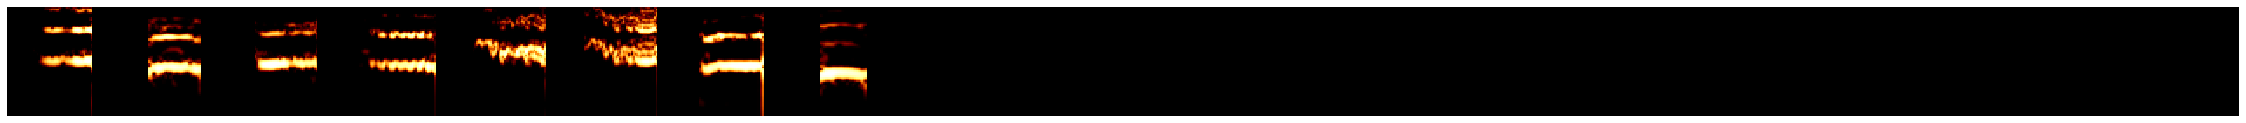

MXXGRY 37


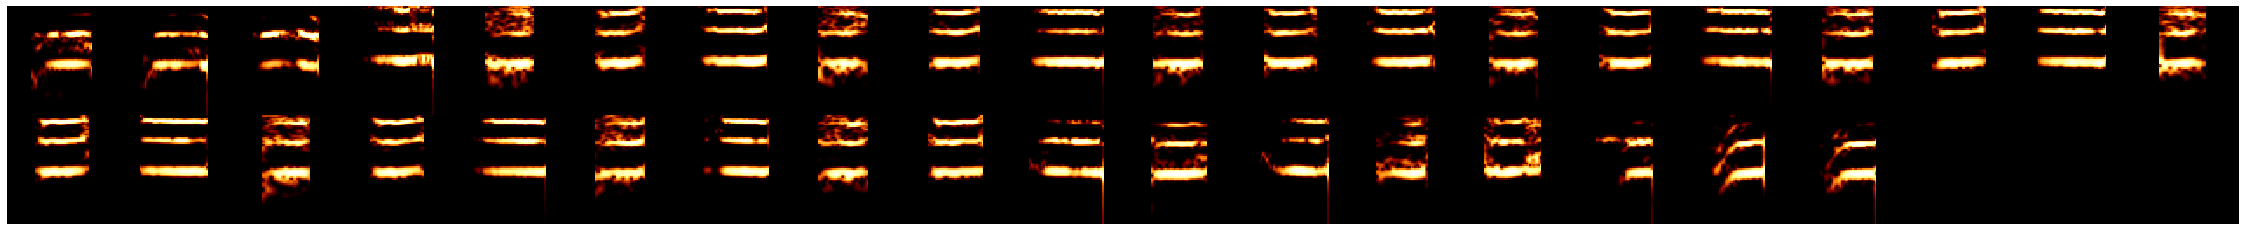

OMGO 44


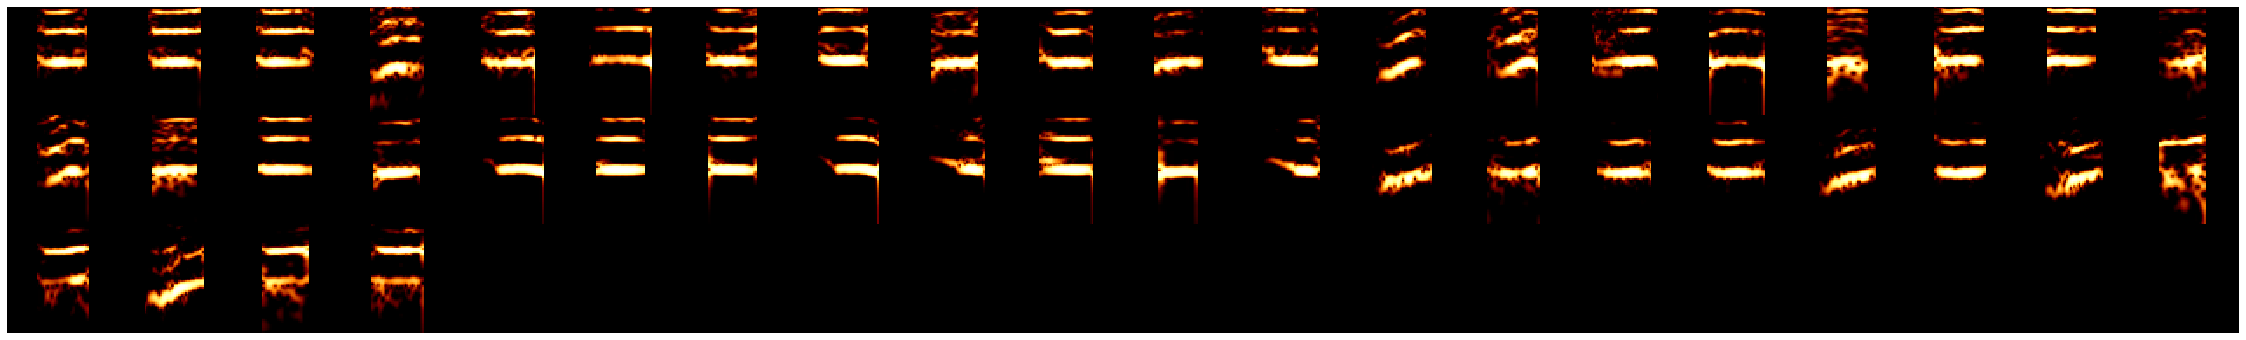

PMXRMX 10


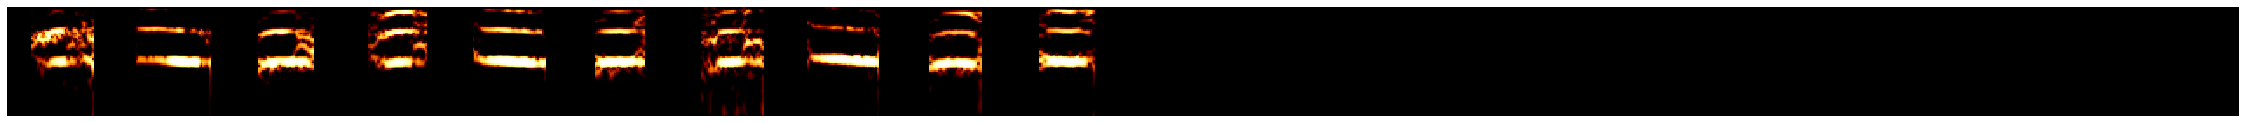

RMXGMX 15


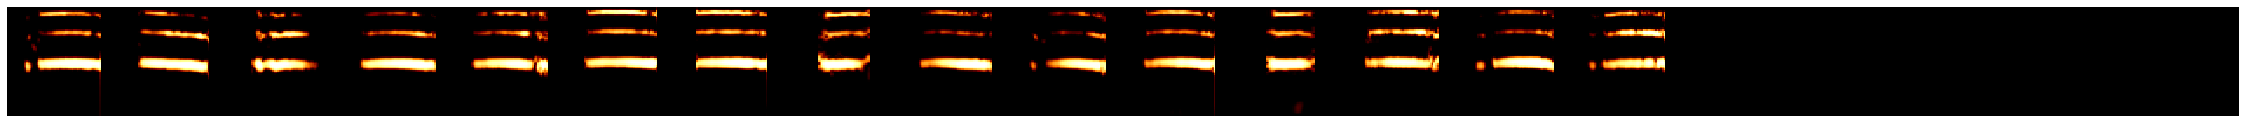

RMYG 13


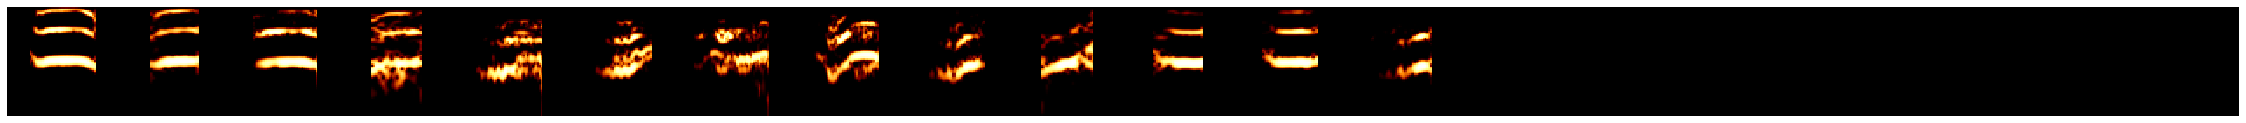

SCL XF 20-21 9


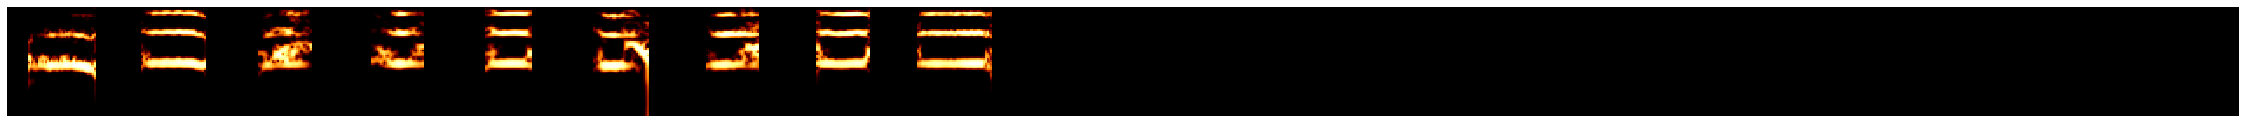

SCL XM 20-21 4


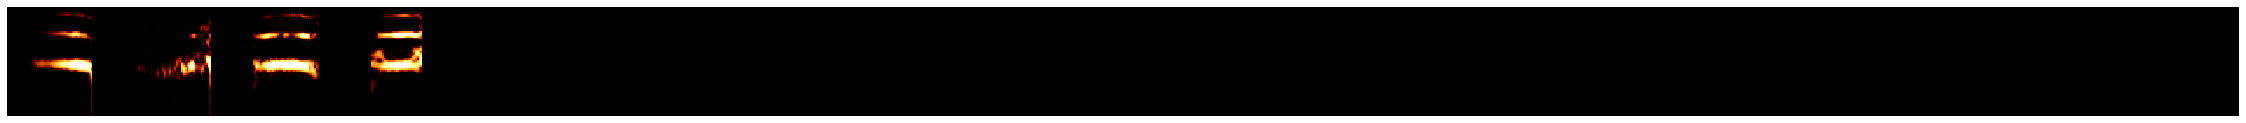

VVOM 46


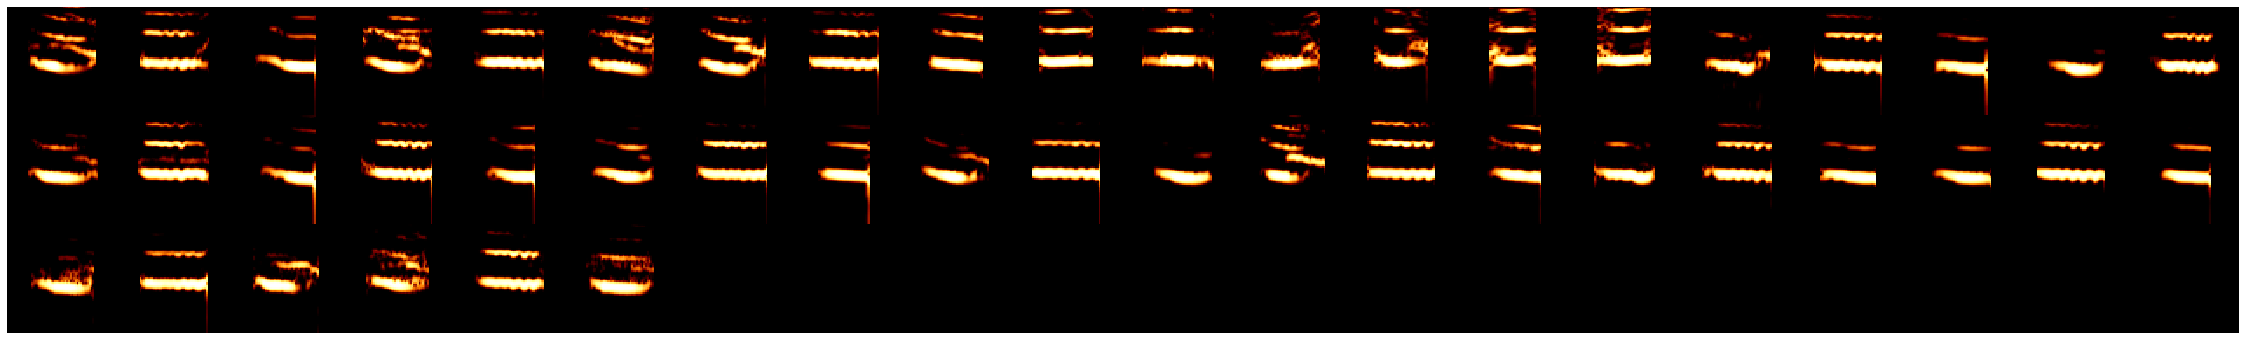

VVVM 35


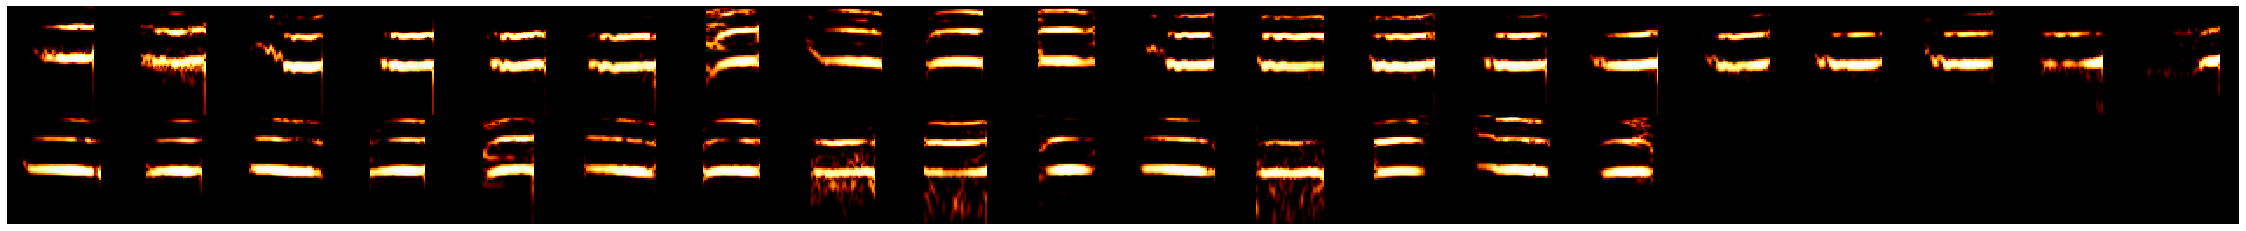

XF 20-21 14


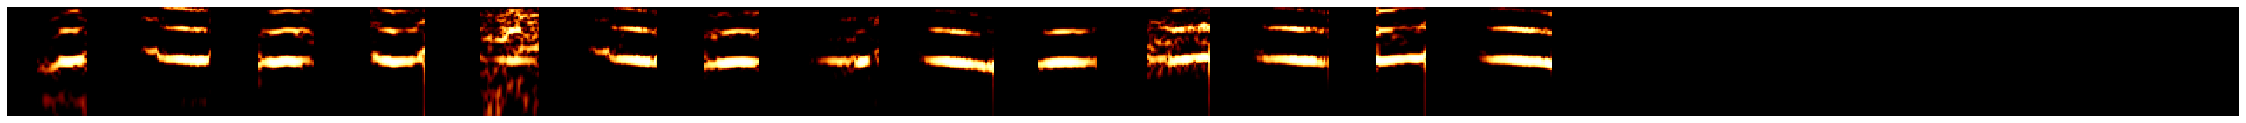

In [25]:
for indv in np.sort(seg_df2.indv.unique()[:]):
    print(indv, np.sum(seg_df2.indv == indv))
    specs = np.array([i/np.max(i) for i in seg_df2[seg_df2.indv == indv].specs.values])
    specs[specs<0] = 0
    
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [26]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [27]:
seg_df2 = seg_df2[np.array([np.sum(i) > 0.0 for i in seg_df2.specs.values])
]

In [28]:
specs = list(seg_df2.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/427 [00:00<?, ?it/s]

(427, 4096)

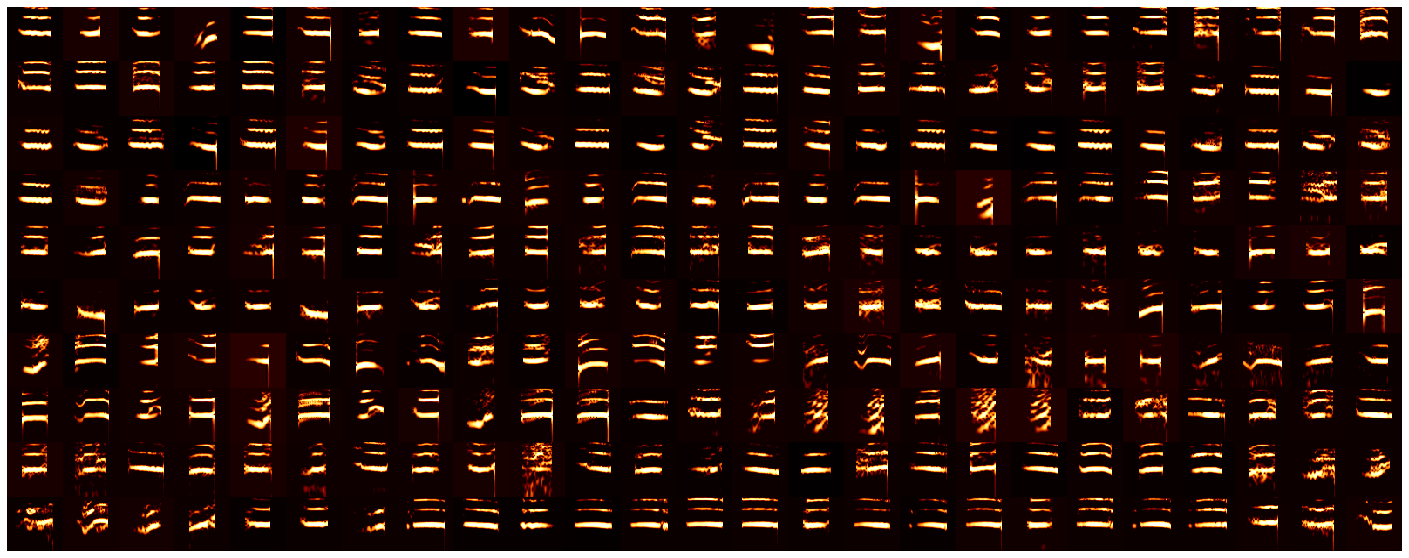

In [29]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [30]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 16 15:44:47 2022 Finding Nearest Neighbors
Tue Aug 16 15:44:49 2022 Finished Nearest Neighbor Search
Tue Aug 16 15:44:50 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 16 15:44:52 2022 Finished embedding


In [56]:
#save df
save_loc = DATA_DIR / DATASET_ID / 'SH' /  'SH.pickle'
ensure_dir(save_loc.as_posix())
seg_df2.to_pickle(save_loc)